Import libraries & data

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import Lasso, LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.preprocessing import PolynomialFeatures

In [2]:
Xy_train = pd.read_csv('datasets/Xy_train_209.csv')
X_train = Xy_train.drop(columns='SalePrice')
y_train = Xy_train['SalePrice']

X_test = pd.read_csv('datasets/X_test_209.csv', )
X_train.shape, y_train.shape, X_test.shape, 

((2051, 391), (2051,), (878, 391))

In [3]:
# scale
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

---
# Modeling

### MLR

cvs: [ 0.28452993  0.6163751  -0.86849151  0.79253952  0.6686115 ]
logged cvs: [ 0.62019686  0.52218212 -0.17540757  0.73643842  0.75275006]


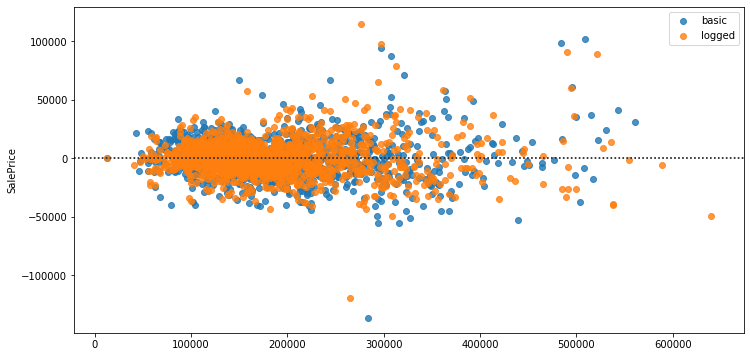

In [4]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_train, y_train, random_state=4)

ols = LinearRegression()
ols.fit(Xs_train, ys_train)
print('cvs:', cross_val_score(ols, Xs_test, ys_test, cv=5))
ys_pred = ols.predict(Xs_train)

ys_train_log = ys_train.apply(np.log)
ys_test_log = ys_test.apply(np.log)

ols = LinearRegression()
ols.fit(Xs_train, ys_train_log)
print('logged cvs:', cross_val_score(ols, Xs_test, ys_test_log, cv=5))
ys_pred_log = ols.predict(Xs_train)
ys_pred_log = np.exp(ys_pred_log)

plt.figure(figsize=(12,6))
sns.residplot(ys_pred, ys_train, label='basic')
sns.residplot(ys_pred_log, ys_train, label='logged')
plt.legend();


In [5]:
y_train_log = y_train.apply(np.log)
ols = LinearRegression()
ols.fit(X_train, y_train_log)
print('score:', ols.score(X_train, y_train_log))
print('cvs:', cross_val_score(ols, X_train, y_train_log, cv=5))
y_pred_log = ols.predict(X_test)
y_pred = np.exp(y_pred_log)

score: 0.952565572001972
cvs: [0.8513259  0.8288231  0.72160999 0.84299866 0.80177691]


In [6]:
# create output df
output = pd.DataFrame( {'Id': X_test['Id']} )
output['SalePrice'] = y_pred

output.head()

#output.to_csv('submissions/submission_209_ols.csv', index=False)

,Id,SalePrice
0,2658,105672.409111
1,2718,154122.341297
2,2414,211303.498026
3,1989,102036.590150
4,625,175602.727210


Okay. Now let's try Ridge.

### Ridge

In [7]:
# Manual alpha
ridge = Ridge(alpha=3)
ridge.fit(Z_train, y_train)
print('a = 3 (manual)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5).mean(), '(mean)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5))

a = 3 (manual)
cvs: 0.8329022168346691 (mean)
cvs: [0.90326295 0.9344129  0.64780629 0.90177697 0.77725197]


In [8]:
# Which alpha should we choose ?
ridge = Ridge(alpha=1200)
ridge.fit(Z_train, y_train)
print('a = 1200 (manual)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5).mean(), '(mean)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5))

a = 1200 (manual)
cvs: 0.8809644431997414 (mean)
cvs: [0.90689462 0.91898451 0.83745687 0.90206881 0.83941741]


Looking better. But I used a random alpha. Maybe RidgeCV can find a better one.

Text(0.5, 1.0, 'logspace')

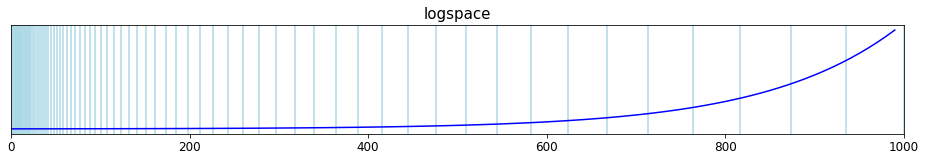

In [26]:
plt.figure(figsize=(16,2))
for vl in np.logspace(.1,3,100):
    plt.axvline(x=vl, color='lightblue')
#plt.axvline(x=316.2277, color='r') #  ymin=.65, ymax=1,
#plt.axvline(x=148.49, ymin=0, ymax=.25, color='red')


sns.lineplot(range(0, 1000, 10), np.logspace(.1,3,100), color='blue')
plt.xlim([0,1000])
plt.xticks(fontsize=12)
plt.yticks([])
plt.title('logspace', fontsize=15)


In [19]:
# Using Matt's example logspace
ridge_alphas = np.logspace(1,3,100)
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Z_train, y_train)
print(f'a = {ridge_cv.alpha_} (found)') 
cvs = cross_val_score(ridge_cv, Z_train, y_train, cv=5)
print('cvs:', cvs.mean(), '(mean)')
print('cvs:', cvs)

a = 1000.0 (found)
cvs: 0.8783548502067994 (mean)
cvs: [0.90773155 0.91981983 0.82245816 0.90196909 0.83979562]


**How does my T/T split affect Ridge CV's alpha?**

In [20]:
for ttseed in [7, 17, 27, 37]: # these numbers get the same....
    # t/t split
    Zs_train, Zs_test, ys_train, ys_test = train_test_split(Z_train, y_train, random_state=ttseed)
    # ridge
    ridge_cv = RidgeCV(alphas=np.logspace(1.5,2.5,100), scoring='r2', cv=5)
    ridge_cv.fit(Zs_train, ys_train)
    train_score = ridge_cv.score(Zs_train, ys_train)
    test_score = ridge_cv.score(Zs_test, ys_test)
    alpha = ridge_cv.alpha_
    print(f'TT seed: {ttseed} | train r2: {train_score} | test r2: {test_score} | alpha = {alpha}')

TT seed: 7 | train r2: 0.9314556032273126 | test r2: 0.9310117008074743 | alpha = 316.22776601683796
TT seed: 17 | train r2: 0.9396456746441714 | test r2: 0.9008558278845855 | alpha = 316.22776601683796
TT seed: 27 | train r2: 0.9460192471067909 | test r2: 0.8236353616369251 | alpha = 316.22776601683796
TT seed: 37 | train r2: 0.9483609249903562 | test r2: 0.8416109344614164 | alpha = 316.22776601683796


In [21]:
def plot_ridge_alphas(rs_range, rs_count, a_range, a_step, y_lim=[.75, 1], np_seed=117, vlines=False, legend=True ):
    plt.figure(figsize=(16,8))
    np.random.seed(np_seed)
    for seed in np.random.randint(0, rs_range, rs_count):
        x = []
        y = []
        for a in range(1, a_range, a_step):   # int list
       # for a in np.logspace(.9, , 100):    # np.log
            x.append(a)
            Zs_train, Zs_test, ys_train, ys_test = train_test_split(Z_train, y_train, random_state=seed)
            ridge = Ridge(alpha=a)
            ridge.fit(Zs_train, ys_train)
            test_score = ridge.score(Zs_test, ys_test)
            y.append(test_score)
        plt.plot(x, y,
                 marker='.',
                 label=seed)
        if vlines==True:
            plt.axvline(x[y.index(max(y))])
    plt.ylim(y_lim)
    plt.ylabel('Test R2', fontsize=14)
    plt.xlim(0, a_range)
    plt.xlabel('.alpha_', fontsize=14)
    if legend==True:
        plt.legend(loc='upper right', title='t-t r split seed');

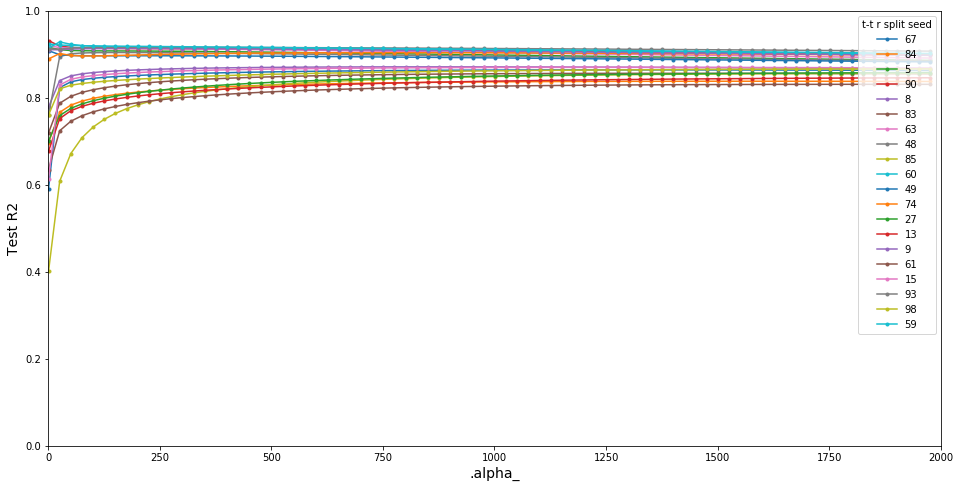

In [25]:
plot_ridge_alphas(100, 20, 2000, 25, y_lim=[0, 1], np_seed=8)

Let's run RidgeCV with every t/t seed between 0-100 to see where they congregate...

In [27]:
# get alphas for ridgeCV in seed range 0-100
alphas = pd.read_csv('datasets/ttseed_alphas.csv')

In [30]:
alphas.median()

0    820.618709
dtype: float64

Text(0, 0.5, 'count')

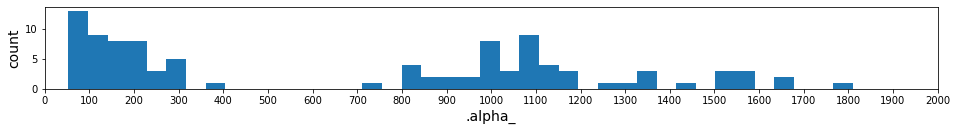

In [15]:
plt.figure(figsize=(16,1.5))
plt.xlim(0, 2000)
plt.hist(alphas['0'], bins=40, );
plt.xticks(range(0, 2100,100));
plt.xlabel('.alpha_', fontsize=14)
plt.ylabel('count', fontsize=14)

Zooming in 0 < α < 100

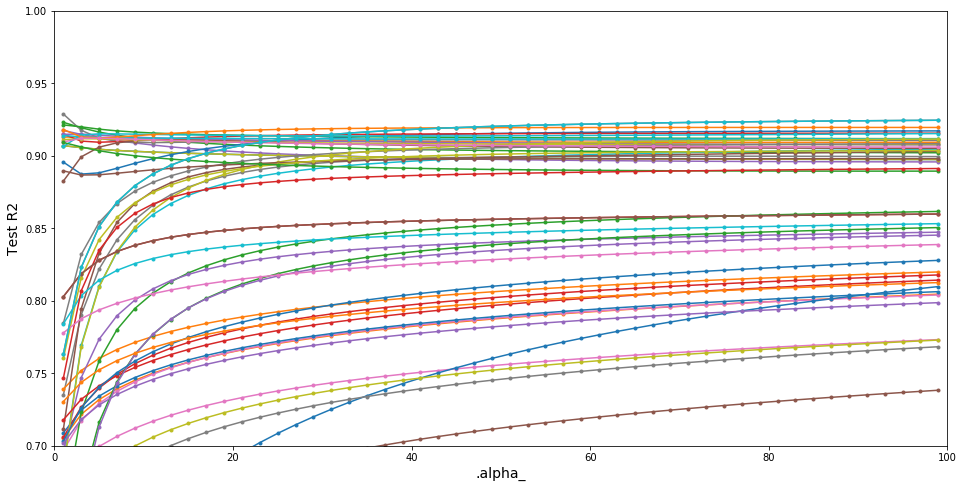

In [16]:
plot_ridge_alphas(500, 50, 100, 2, y_lim=[.7, 1], legend=False)

Let's try to figure out what's going on in one of our stranger splits

In [17]:
# rs = 55 is really strange
Zs_train, Zs_test, ys_train, ys_test = train_test_split(Z_train, y_train, random_state=26)
ridge_alphas = np.logspace(1,3,100)
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Zs_train, ys_train)
ridge_cv.score(Zs_train, ys_train), ridge_cv.score(Zs_test, ys_test), ridge_cv.alpha_

(0.9219339794533724, 0.9203314342363625, 1000.0)

In [18]:
print('train:', ridge_cv.score(Zs_train, ys_train))
print('test:',  ridge_cv.score(Zs_test, ys_test))
print('alpha:', ridge_cv.alpha_)

train: 0.9219339794533724
test: 0.9203314342363625
alpha: 1000.0


In [19]:
# split with rs55, manual alpha
ridge = Ridge(alpha=80)
ridge.fit(Zs_train, ys_train)
print('a = 80 (manual) | rs = 55')
print('cvs:', cross_val_score(ridge, Zs_train, ys_train, cv=5).mean(), '(mean)')
print('cvs:', cross_val_score(ridge, Zs_train, ys_train, cv=5))

a = 80 (manual) | rs = 55
cvs: 0.8297945643189653 (mean)
cvs: [0.90153531 0.55082023 0.91741137 0.88172643 0.89747948]


Finally, predict using RidgeCV searching within our optimal alpha range

In [20]:
y_train_log = y_train.apply(np.log) 

In [21]:
ridge_alphas = np.logspace(1.5,1.9,100)
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Z_train, y_train)
ridge_cv.score(Z_train, y_train), ridge_cv.alpha_

(0.9429181574492387, 79.43282347242814)

In [22]:
y_pred = ridge_cv.predict(Z_test)

In [23]:
# create output df
output = pd.DataFrame( {'Id': X_test['Id']} )
output['SalePrice'] = np.exp(y_pred)

output.head()

/Users/jfitz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


,Id,SalePrice
0,2658,inf
1,2718,inf
2,2414,inf
3,1989,inf
4,625,inf


In [24]:
#output.to_csv('submissions/submission_209_ridge.csv', index=False)

In [25]:
Lasso=

SyntaxError: invalid syntax (<ipython-input-25-504059cedaf6>, line 1)